1.) Imports and Define Functions

In [63]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import copy
import time

def standardize(x):
    if x.size == 1:
        return 0
    else:
        x_std = (x - np.mean(x))/np.std(x)
        return(x_std)

def destandardize(x_std, x):
    if x.size == 1:
        return x
    else:
        x_old = (x_std * np.std(x)) + np.mean(x)
        return(x_old)

2.) Load Data

In [65]:
df_drillCost = pd.read_excel('C:/Users/ambue/OneDrive/Documents/Working_Directory/Analysis_Data.xlsx', 
                       sheet_name='Drilling Cost', skiprows=2)  
df_projection = pd.read_excel('C:/Users/ambue/OneDrive/Documents/Working_Directory/Analysis_Data.xlsx', 
                       sheet_name='Price Projections', skiprows=2)  

3.) Simulation Parameters and Distributions

In [67]:
# cost of a dry well
simSize = 1000000

# probability of a wet well 
a, b = (0 - 0.99) / 0.05, (1 - 0.99) / 0.05
hydrocarbon = truncnorm.rvs(a, b, loc=0.99, scale=0.05, size=simSize)
a, b = (0 - 0.8) / 0.1, (1 - 0.8) / 0.1
reservoir = truncnorm.rvs(a, b, loc=0.8, scale=0.1, size=simSize)

4.) Visualizations

C:\Users\ambue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


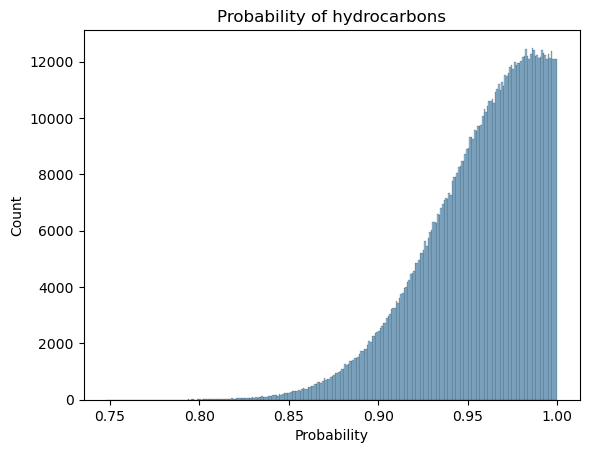

C:\Users\ambue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


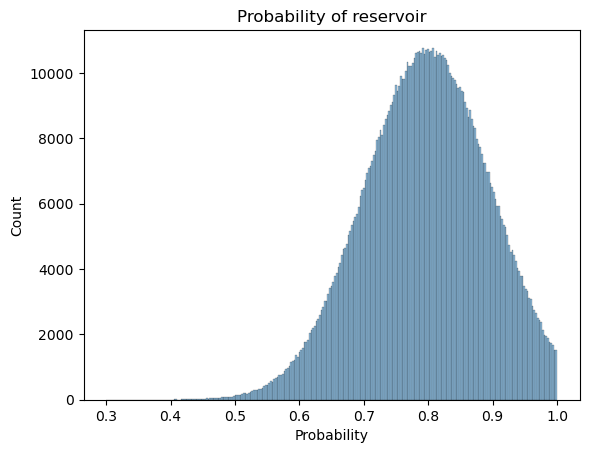

In [69]:
# histogram for probability of hydrocarbon
ax = sns.histplot(data = pd.DataFrame(hydrocarbon), legend=False)
ax.set(xlabel = "Probability")
ax.set_title("Probability of hydrocarbons")
plt.show()

# histogram for probability of reservoir
ax = sns.histplot(data = pd.DataFrame(reservoir), legend=False)
ax.set(xlabel = "Probability")
ax.set_title("Probability of reservoir")
plt.show()

5.) Well Analysis

In [71]:
noWells = np.random.randint(low=10, high=31, size=simSize) 
wetProb = hydrocarbon * reservoir

typeWell = [[np.random.binomial(n=1, p=np.random.choice(wetProb, 1)).item() 
             for y in range(noWells[x])] for x in range(simSize)]

6.) Proportion of Dry/Wet Wells

In [73]:
df_proportion = pd.DataFrame()
df_proportion['no of well'] = noWells
df_proportion['no of wet well'] = [x.count(1) for x in typeWell]
df_proportion['wet proportion'] = df_proportion['no of wet well'] / df_proportion['no of well']
df_proportion['dry proportion'] = 1 - df_proportion['wet proportion']

7.) Histogram of Well Proportions

C:\Users\ambue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


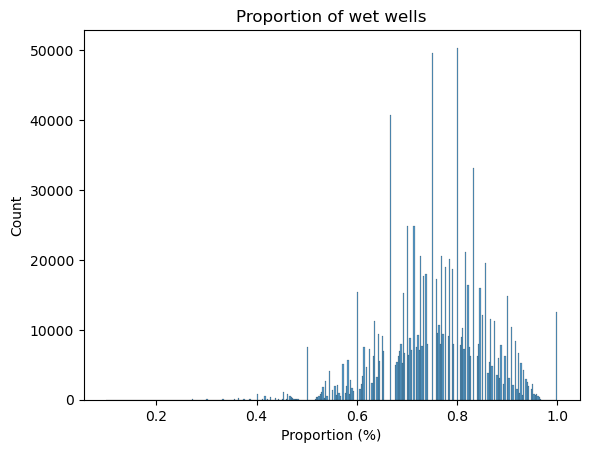

In [75]:
ax = sns.histplot(data=df_proportion['wet proportion'], legend=False)
ax.set(xlabel="Proportion (%)")
ax.set_title("Proportion of wet wells")
plt.show()

8.) Value at Risk Calculations

In [77]:
VaR = np.percentile(df_proportion['wet proportion'], 5)
CVaR = np.mean(df_proportion[df_proportion['wet proportion'] < VaR][['wet proportion']])

9.) Drilling Cost Simulation

In [79]:
P0 = df_drillCost[df_drillCost['Date']=='2006-06-30'].iloc[:, 1:4].mean(axis=1).item() * 1000
drillStart = [np.full(df_proportion['no of well'][x], P0) for x in range(simSize)]

10.) Investment Return Simulations

In [81]:
ret = [np.random.normal(loc=0.131, scale=0.178, size=df_proportion['no of well'][x]) for x in range(simSize)]
drilling = [drillStart[x] * (1 + ret[x]) for x in range(simSize)]

11.) Additional Cost Factors

In [83]:
seismic = [np.random.normal(loc=3, scale=0.35, size=df_proportion['no of well'][x]) for x in range(simSize)]
lease = [np.random.normal(loc=600, scale=50, size=df_proportion['no of well'][x]) for x in range(simSize)]
overhead = [np.random.triangular(172000, 215000, 279000, size=df_proportion['no of well'][x]) for x in range(simSize)]
y0exp = [drilling[x] + seismic[x]*43000 + lease[x]*960 + overhead[x] for x in range(simSize)]

12.) Net Present Value Calculation

In [85]:
completion = [np.random.normal(loc=390000, scale=50000, size=df_proportion['no of wet well'][x]) for x in range(simSize)]
IP = [np.random.lognormal(mean=6, sigma=0.28, size=df_proportion['no of wet well'][x]) for x in range(simSize)]
decline = [np.random.uniform(low=0.15, high=0.32, size=df_proportion['no of wet well'][x]) for x in range(simSize)]

13.) Correlation Adjustments

In [87]:
R = np.array([[1, 0.64], [0.64, 1]])
U = sp.linalg.cholesky(R, lower=False)
Both_rate = [np.array([standardize(IP[x]), standardize(decline[x])]) for x in range(simSize)]
bend = [U @ Both_rate[x] for x in range(simSize)]
final_rate = [np.array([destandardize(bend[x][0], IP[x]), destandardize(bend[x][1], decline[x])]) for x in range(simSize)]

14.) Simulation Execution

1453.891103029251


C:\Users\ambue\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


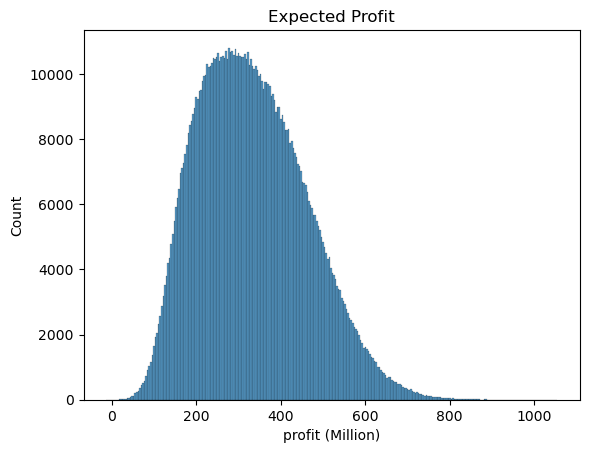

array([], shape=(0, 1), dtype=int64)

In [92]:
# revenue interest
interest = [np.random.normal(loc=0.75, scale=0.02, size=df_proportion['no of wet well'][x]) for x in range(simSize)]
    
yearBegin = [np.array(final_rate[x][0]) for x in range(simSize)]

start = time.time()

# start simulation with only Y0 cost 
npv = [-1*(y0exp[x][0:df_proportion['no of wet well'][x]]+completion[x]) for x in range(simSize)]
# forcast for the next 15 years
for i in range(15):
    # year end production rate
    yearEnd = [yearBegin[x]*(1-final_rate[x][1]) for x in range(simSize)]
    # production volumn
    production = [365*(yearBegin[x]+yearEnd[x])/2 for x in range(simSize)]
    
    # oil price
    low = df_projection[df_projection['Year']==2026+i]['Low Oil Price'].item()
    high = df_projection[df_projection['Year']==2026+i]['High Oil Price'].item()
    exp = df_projection[df_projection['Year']==2026+i]['AEO2023 Reference'].item()
    price = [np.full(df_proportion['no of wet well'][x], np.random.triangular(low, exp, high)) for x in range(simSize)]
    
    # net revenue & severance tax
    revenue = [production[x]*price[x]*interest[x]*(1-0.046) for x in range(simSize)]
    
    # operating cost, same for every well
    operate = [np.full(df_proportion['no of wet well'][x], np.random.normal(loc = 2.25, scale = 0.3)) for x in range(simSize)]
    
    # net present value
    npv = [npv[x] + (revenue[x]-operate[x]-overhead[x][0:df_proportion['no of wet well'][x]])/[1.1**(i+1)] for x in range(simSize)]
    
    yearBegin = copy.deepcopy(yearEnd)
        
# expected profit for each simulation
expProfit = [npv[x].sum()-y0exp[x][df_proportion['no of wet well'][x]:].sum() for x in range(simSize)]

end = time.time()
length = end - start
print(length)

expProfit = np.array(expProfit)/1000000
# histogram for expected profit
ax = sns.histplot(data = expProfit, legend=False)
ax.set(xlabel = "profit (Million)")
ax.set_title("Expected Profit")
plt.show()

exp_VaR = np.percentile(expProfit, 5) 
# 5% CVaR
exp_CVaR = np.mean(expProfit[expProfit < exp_VaR])

from scipy.stats import percentileofscore
percentileofscore(expProfit, 0)

import math
len([0 for x in expProfit if math.isnan(x)])
np.argwhere(np.isnan(expProfit))